# Notebook to show horizontal mixing and diffusive boundary fluxes are small and do not meaningfully impact quantification of numerical mixing or the accuracy of the offline methods 

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

#Dask
from dask.distributed import Client

client = Client()
client

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

2023-01-03 13:05:00,744 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-xnt5o2u9', purging
2023-01-03 13:05:00,745 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-vygk717j', purging
2023-01-03 13:05:00,745 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_v70s3yh', purging
2023-01-03 13:05:00,746 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-6cz5r7o9', purging
2023-01-03 13:05:00,747 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-u45eh3hp', purging
2023-01-03 13:05:00,747 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-yjtxpymz', purging
2023-01-03 13:05:00,747 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-rmegn0x_', purging

In [7]:
# Open all output from 60 min, 30 min, 10 min frequency
#Tendency
ds2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/ds2dt_parent_ver1_2010.npy')
dsprime2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/dsprime2dt_ver1_parent_2010.npy')

#Advection
s2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltsquareadv_parent_ver1_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltvaradv_parent_ver1_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Surface
s2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/s2flux_ver1_2010_*.nc').s2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/sprime2flux_ver1_2010_*.nc').sprime2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Online resolved and numerical mixing
chi_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_ver1_2010_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
mnum_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_ver1_2010_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Horizontal mixing 
chih = xr.open_dataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/chi_horz/chih_parent_hgrad.nc').chih_parent
chi_tot = chih+chi_online

#Horizontal diffusion
s2_diff_flux = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/s2_horz/s2_horz_diff_parent_*.nc').s2_diff_flux
sprime2_diff_flux = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/sprime2_horz/sprime2_horz_diff_parent_*.nc').s2_diff_flux
sbarsprime_diff_flux = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/sbarsprime_hdiffusion_60min_*.nc').sbarsprime_diff_flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Offline numerical mixing with horizontal mixing and boundary diffusion
mnum_ss = -(ds2dt+s2_advection+chi_tot-s2_surface-s2_diff_flux)
mnum_sprime2 = -(dsprime2dt+sprime2_advection+chi_tot-sprime2_surface-sprime2_diff_flux)

#Offline numerical mixing without horizontal mixing
mnum_ss_no_hmix = -(ds2dt+s2_advection+chi_online-s2_surface-s2_diff_flux)
mnum_sprime2_no_hmix = -(dsprime2dt+sprime2_advection+chi_online-sprime2_surface-sprime2_diff_flux)

#Offline numerical mixing without horizontal boundary diffusion but with horizontal mixing
mnum_ss_no_hdiff = -(ds2dt+s2_advection+chi_tot-s2_surface)
mnum_sprime2_no_hdiff = -(dsprime2dt+sprime2_advection+chi_tot-sprime2_surface)

#Offline numerical mixing without horizontal boundary diffusion and horizontal mixing - initial submission
mnum_ss_no_hmixhdiff = -(ds2dt+s2_advection+chi_online-s2_surface)
mnum_sprime2_no_hmixhdiff = -(dsprime2dt+sprime2_advection+chi_online-sprime2_surface)
#Define time for plotting
time = chi_online.ocean_time.values

In [3]:
def per_change(final, initial):
    perchange = 100*((final-initial)/np.abs(initial))
    return perchange

r1 = per_change(mnum_ss.sum().values, mnum_ss_no_hmix.sum().values)
print(r1)
r2 = per_change(mnum_ss.sum().values, mnum_ss_no_hdiff.sum().values)
print(r2)
r3 = per_change(mnum_ss.sum().values, mnum_ss_no_hmixhdiff.sum().values)
print(r3)
r4 = per_change(mnum_sprime2.sum().values, mnum_sprime2_no_hmix.sum().values)
print(r4)
r5 = per_change(mnum_sprime2.sum().values, mnum_sprime2_no_hdiff.sum().values)
print(r5)
r6 = per_change(mnum_sprime2.sum().values, mnum_sprime2_no_hmixhdiff.sum().values)
print(r6)

-2.4423778461123846
-0.3918637046883199
-2.815369419340091
-2.4787021197013797
0.5164335583369484
-1.9876158287671282


# Summary plot 

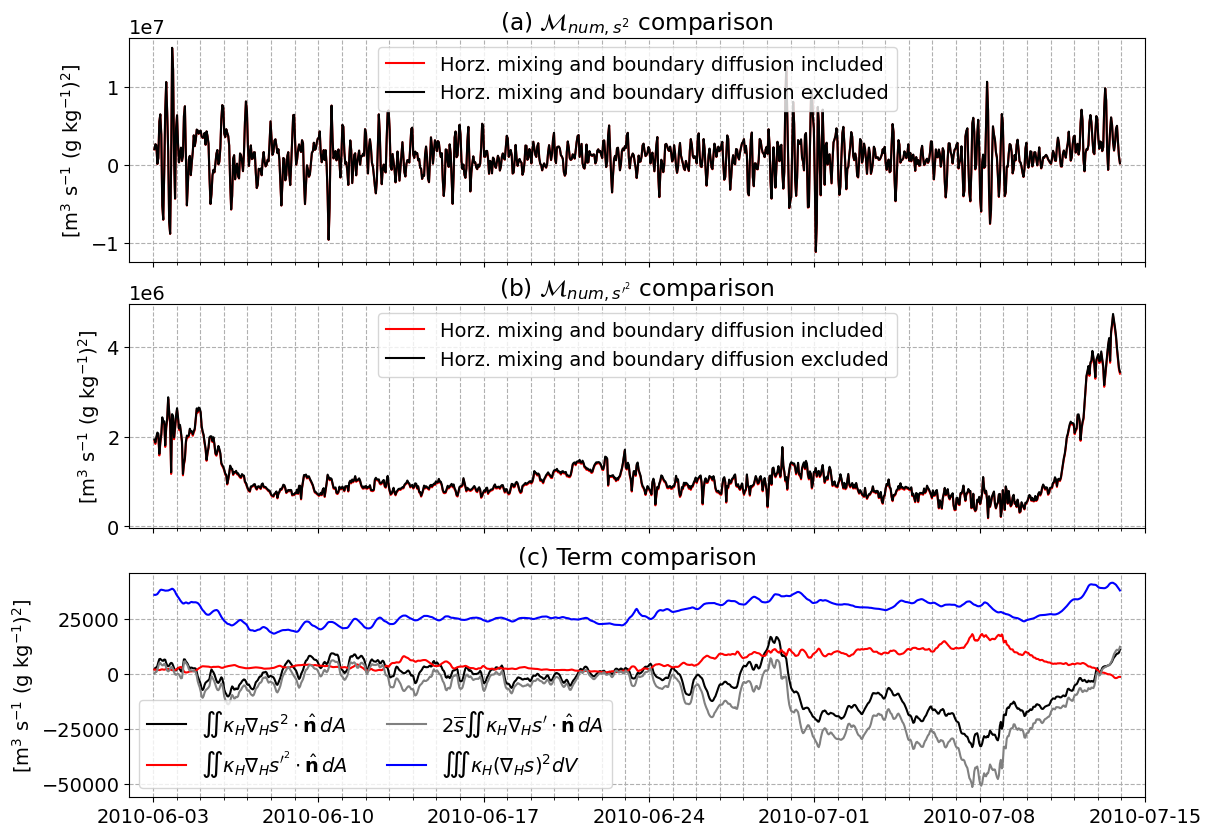

In [4]:
plt.rcParams.update({'font.size': 14})

#Format the date-ticks
myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

fig, ax = plt.subplots(3,1, figsize = (12,2.75*3), constrained_layout = True, sharey = False)

ax[0].plot(time, mnum_ss, lw = 1.5, c = 'r', label = r'Horz. mixing and boundary diffusion included')
ax[0].plot(time, mnum_ss_no_hmixhdiff, lw = 1.5, c = 'k', label = r'Horz. mixing and boundary diffusion excluded')
ax[0].set_title('(a) $\mathcal{M}_{num, s^2}$ comparison')
ax[0].legend(loc = 'upper center', ncol = 1)

ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[0].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[0].set_xticks(ticks = dates)
ax[0].grid(linestyle = '--')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])

ax[1].plot(time, mnum_sprime2, lw = 1.5, c = 'r', label = r'Horz. mixing and boundary diffusion included')
ax[1].plot(time, mnum_sprime2_no_hmixhdiff, lw = 1.5, c = 'k', label = r'Horz. mixing and boundary diffusion excluded')
ax[1].set_title('(b) $\mathcal{M}_{num, s^{\prime^2}}$ comparison')
ax[1].legend(loc = 'upper center', ncol = 1)
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[1].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[1].set_xticks(ticks = dates)
ax[1].grid(linestyle = '--')
ax[1].set_xlabel('')
ax[1].set_xticklabels([])

ax[2].plot(time, s2_diff_flux[1:-1], lw = 1.5, c = 'k', label = r'$\iint \kappa_H \nabla_H s^2 \cdot \hat{\mathbf{n}} \, dA$')
ax[2].plot(time, sprime2_diff_flux[1:-1], lw = 1.5, c = 'r', label = r'$\iint \kappa_H \nabla_H s^{\prime^2} \cdot \hat{\mathbf{n}} \, dA$')
ax[2].plot(time, sbarsprime_diff_flux, lw = 1.5, c = 'grey', label = r'$2 \overline{s} \iint \kappa_H \nabla_H s^{\prime} \cdot \hat{\mathbf{n}} \, dA$')
ax[2].plot(time, chih[1:-1], lw = 1.5, c = 'b', label = r'$\iiint \kappa_H (\nabla_H s)^2 dV$')
ax[2].set_title('(c) Term comparison')
ax[2].legend(loc = 'lower left', ncol = 2)
ax[2].xaxis.set_major_formatter(myFmt)
ax[2].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[2].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[2].set_xticks(ticks = dates)
ax[2].grid(linestyle = '--')
ax[2].set_xlabel('')

for i in range(3):
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    minor_locator = AutoMinorLocator(7)
    ax[i].yaxis.grid(True, linestyle = '--')
    ax[i].xaxis.set_minor_locator(minor_locator)
    ax[i].xaxis.grid(True, which = 'both', linestyle = '--')
    
plt.savefig('editor_response.jpg', dpi = 300, bbox_inches='tight')